#1 Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

#2 Load Dataset

In [2]:
data = pd.read_csv('ecommerce_customer_data_custom_ratios.csv')
data.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


#3 Basic Data Exploration & Cleaning

In [3]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns \n')
print(data.isnull().sum())
print('\n')

Dataset contains 250000 rows and 13 columns 

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64




In [4]:
print(data.dtypes)
print('\n')
print(f'Duplicate rows: {data.duplicated().sum()}')

Customer ID                int64
Purchase Date             object
Product Category          object
Product Price              int64
Quantity                   int64
Total Purchase Amount      int64
Payment Method            object
Customer Age               int64
Returns                  float64
Customer Name             object
Age                        int64
Gender                    object
Churn                      int64
dtype: object


Duplicate rows: 0


#4 Data Preprocessing

a) Drop Unnecessary Colummns

In [5]:
# Drop customer_Id and customer_name
data.drop(columns=['Customer Name','Customer ID'],inplace=True)

b) Convert Purchase Date to Datetime & Extract Features

In [6]:
data['Purchase Date'] = pd.to_datetime(data['Purchase Date'])
data['Year'] = data['Purchase Date'].dt.year
data['Month'] = data['Purchase Date'].dt.month
data['Day']=data['Purchase Date'].dt.day

# Drop original purchase date
data.drop(columns=['Purchase Date'],inplace=True)

c) Find unique values in categorical column

In [7]:
categorical_column = data.select_dtypes(include=['object']).columns
for col in categorical_column:
    print(f"Unique Values in '{col}': {data[col].unique()}")

Unique Values in 'Product Category': ['Electronics' 'Home' 'Clothing' 'Books']
Unique Values in 'Payment Method': ['Credit Card' 'PayPal' 'Cash' 'Crypto']
Unique Values in 'Gender': ['Male' 'Female']


d) Encode categorical variables

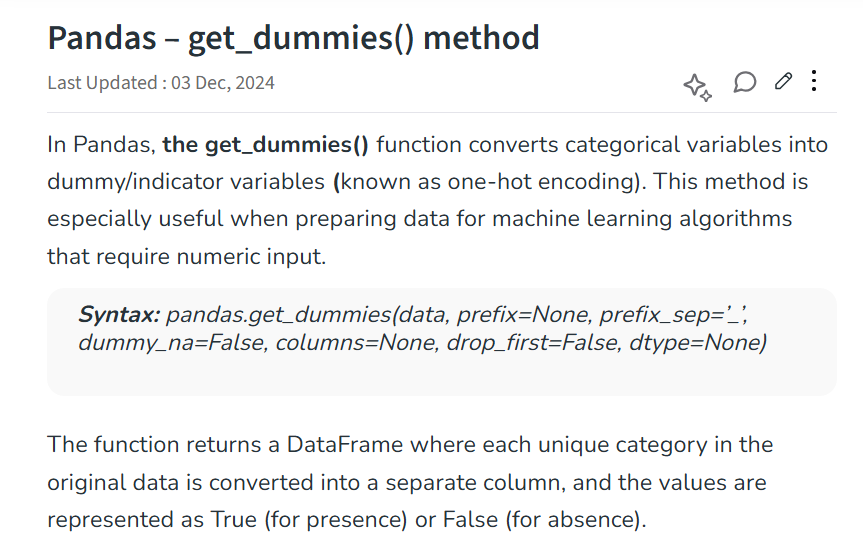

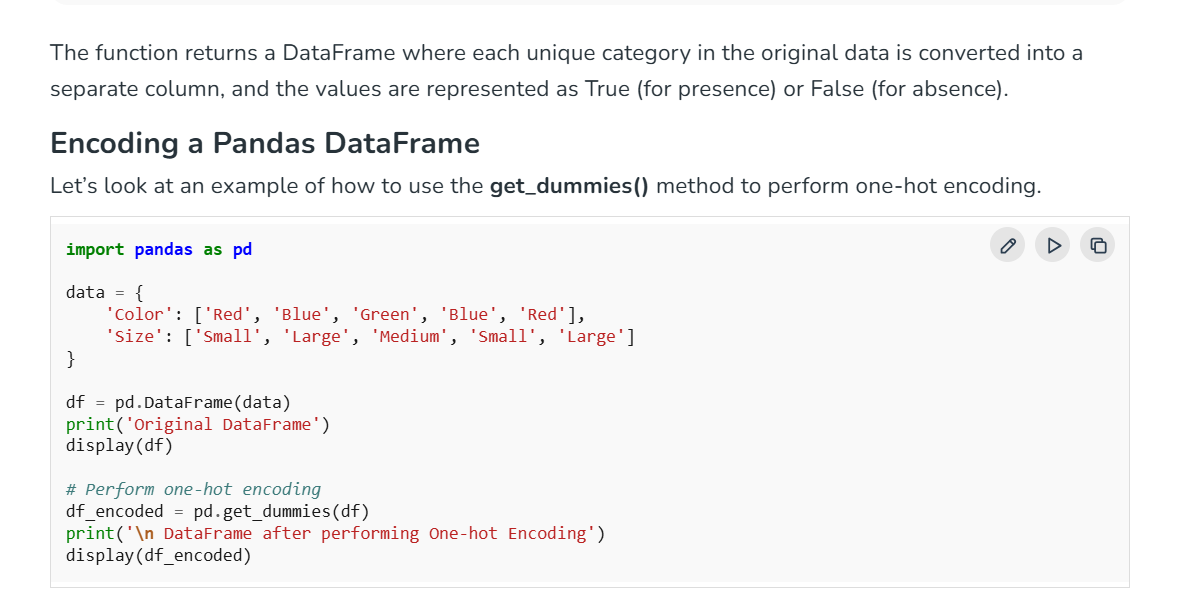

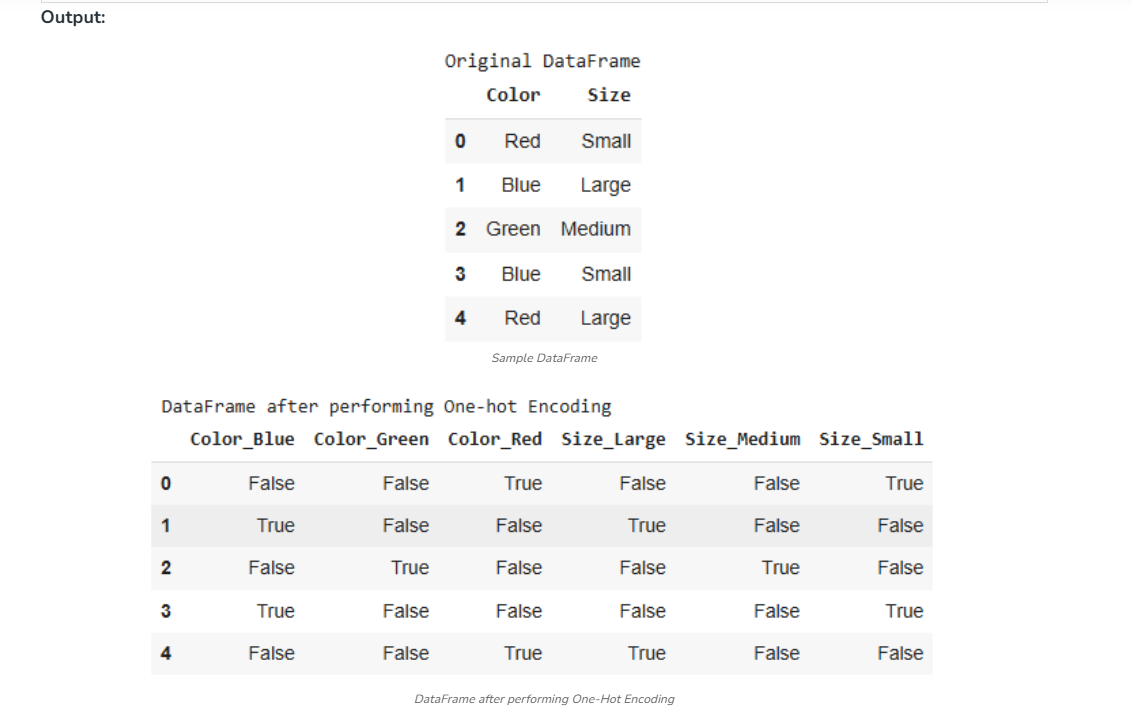

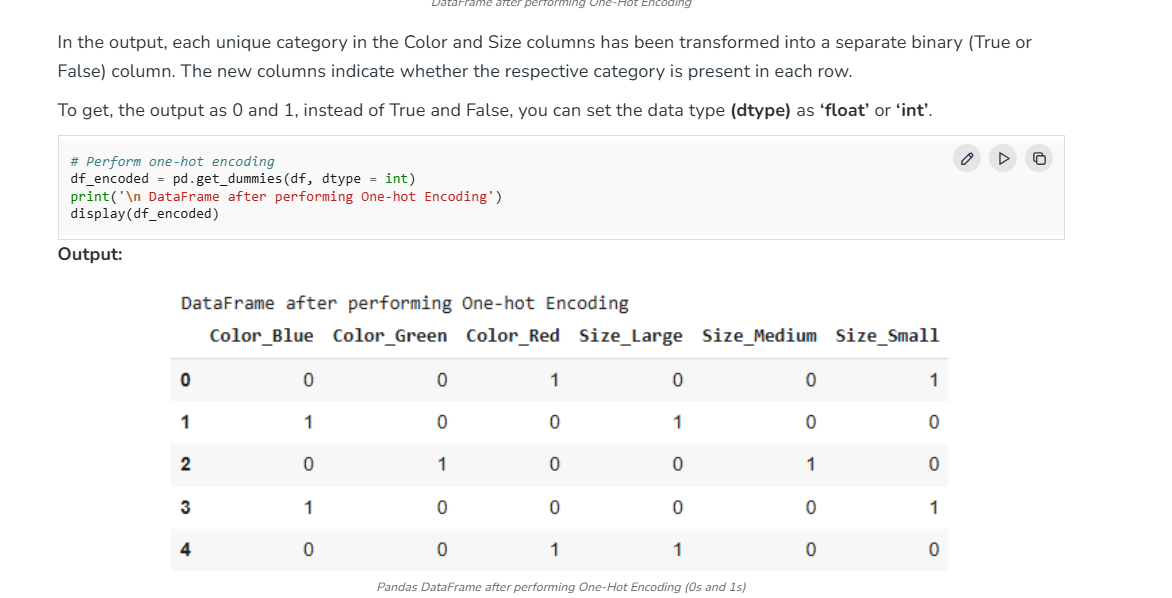

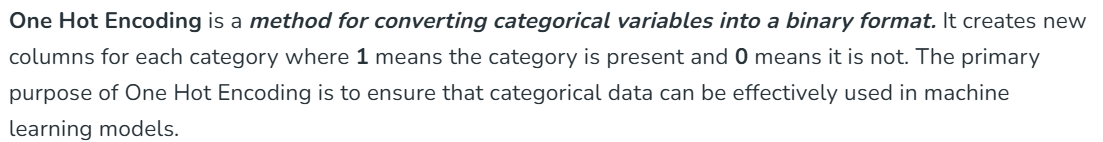

In [8]:
# One hot encoding
data = pd.get_dummies(data,columns=['Gender','Payment Method','Product Category'],drop_first=True)

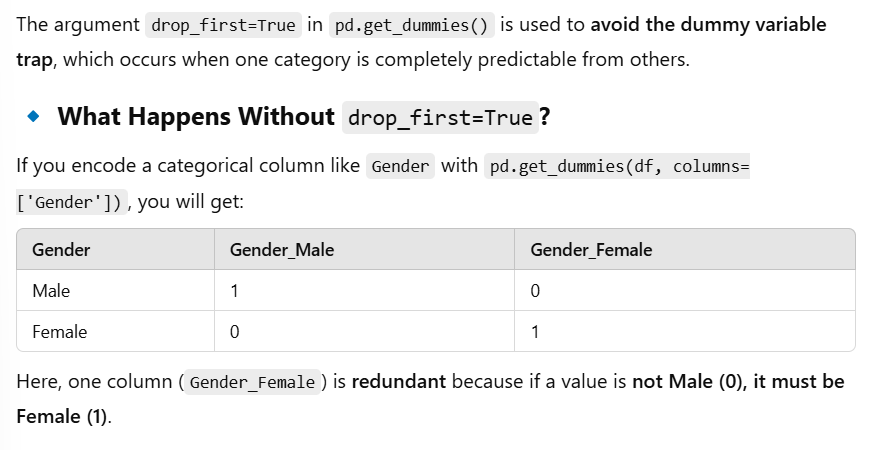 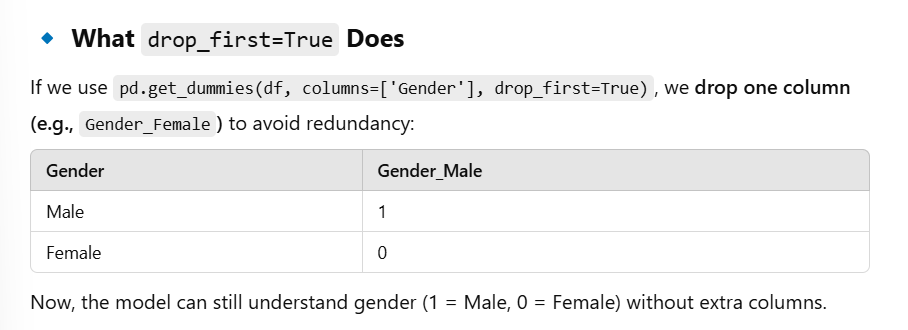

e) Handling missing values

In [9]:
data.isnull().sum()

Product Price                       0
Quantity                            0
Total Purchase Amount               0
Customer Age                        0
Returns                         47596
Age                                 0
Churn                               0
Year                                0
Month                               0
Day                                 0
Gender_Male                         0
Payment Method_Credit Card          0
Payment Method_Crypto               0
Payment Method_PayPal               0
Product Category_Clothing           0
Product Category_Electronics        0
Product Category_Home               0
dtype: int64

In [10]:
data.update(data[['Returns']].fillna(data['Returns'].mode()[0]))
data.isnull().sum()

Product Price                   0
Quantity                        0
Total Purchase Amount           0
Customer Age                    0
Returns                         0
Age                             0
Churn                           0
Year                            0
Month                           0
Day                             0
Gender_Male                     0
Payment Method_Credit Card      0
Payment Method_Crypto           0
Payment Method_PayPal           0
Product Category_Clothing       0
Product Category_Electronics    0
Product Category_Home           0
dtype: int64

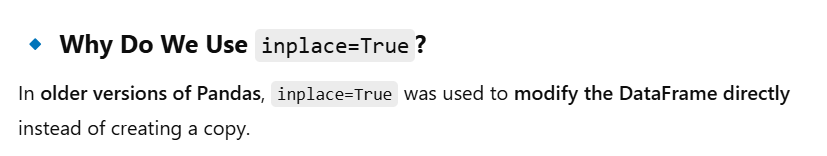

#5 Handle Imbalanced Data

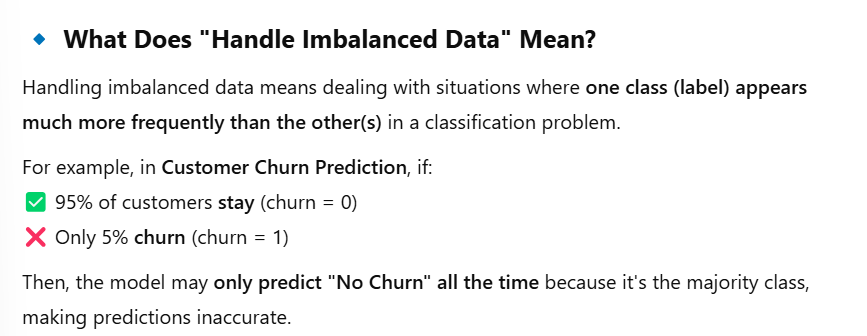

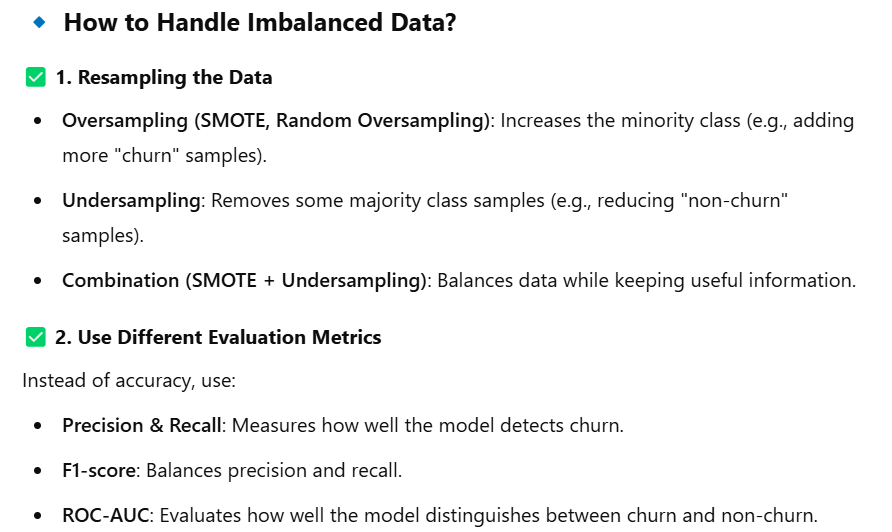

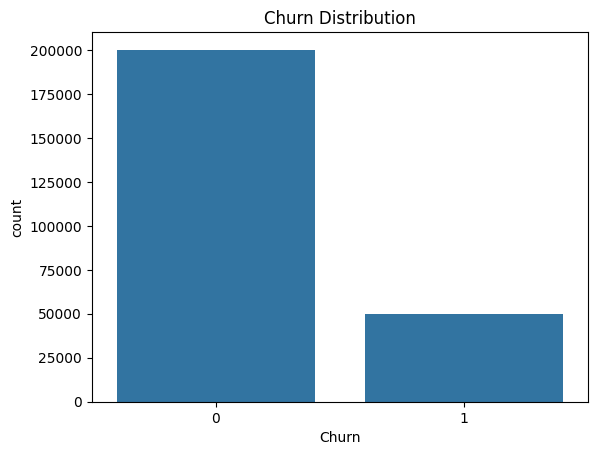

Churn
0    80.0504
1    19.9496
Name: count, dtype: float64


In [11]:
# Since churn is a classification problem, we need to check if the dataset is imbalanced.
sns.countplot(x=data['Churn'])
plt.title('Churn Distribution')
plt.show()

print(((data['Churn'].value_counts())/len(data))*100)

In [12]:
# Dataset is imbalanced, Apply SMOTE(Synthetic Minority Overshampling Technique) to balance the class
from imblearn.over_sampling import SMOTE 

x=data.drop(columns=['Churn'])
y=data['Churn']

smote = SMOTE(random_state=42)
x_reshampled,y_reshampled = smote.fit_resample(x,y)

# Check the balance of the resampled data
print(f"Original class distribution:\n{y.value_counts()}")
print(f"Resampled class distribution:\n{y_reshampled.value_counts()}")

Original class distribution:
Churn
0    200126
1     49874
Name: count, dtype: int64
Resampled class distribution:
Churn
0    200126
1    200126
Name: count, dtype: int64


#6 Normlaize Numeric Features

In [13]:
# We standardize numerical values to improve model performance.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['Customer Age','Product Price','Quantity','Total Purchase Amount']
x_reshampled[numeric_cols] = scaler.fit_transform(x_reshampled[numeric_cols])

#7 Train the Model

a) Split data into Train, Test, and Validation Sets

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x_reshampled,y_reshampled,test_size=0.3,random_state=42)
x_val, x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42)


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Check the size of each
print(f'Training Set: {x_train.shape[0]} samples')
print(f'Validation Set: {x_val.shape[0]} samples')
print(f'Testing Set: {x_test.shape[0]} samples')

Training Set: 280176 samples
Validation Set: 60038 samples
Testing Set: 60038 samples


b) Apply K-Fold Cross-Validation on Training Data

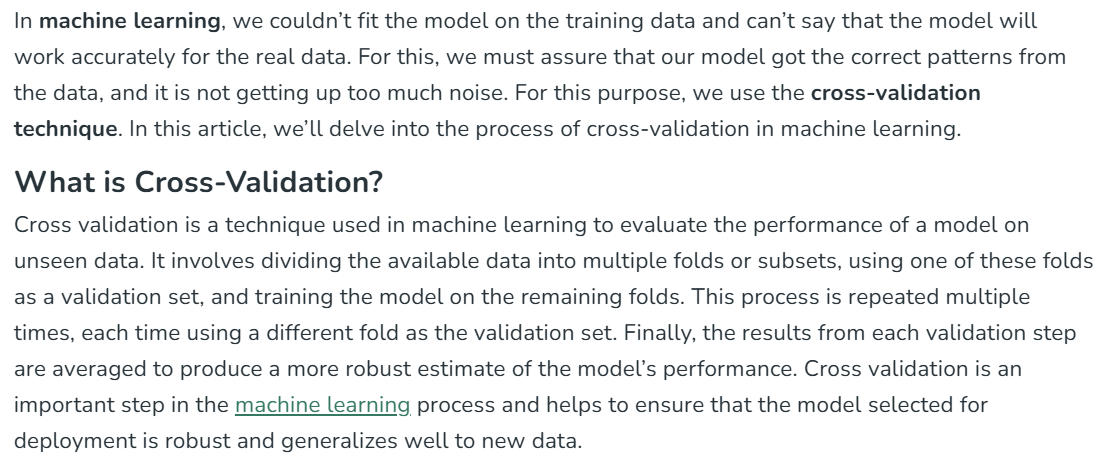 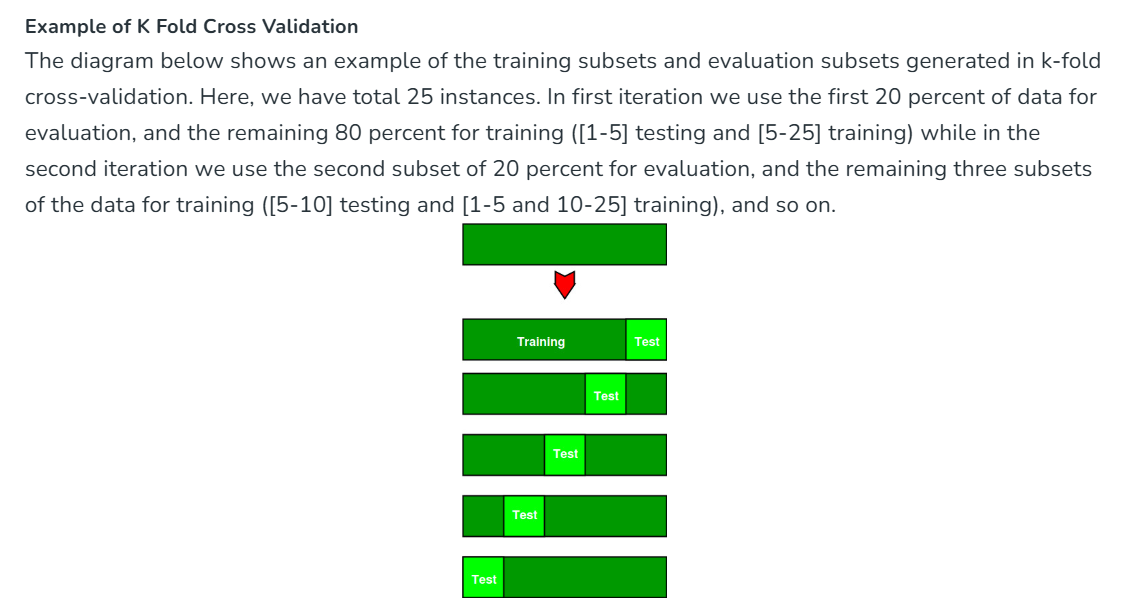

In [15]:
# We perform K-Fold Cross-Validation (e.g., 5-fold) 
# on the training set to ensure model robustness.

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=500, random_state=42)

cv_results = cross_validate(model,x_train,y_train,cv=5,scoring=['accuracy','precision','recall','f1'])

# Display the results for each fold
print(f"Accuracy per fold: {cv_results['test_accuracy']}")
print(f"Precision per fold: {cv_results['test_precision']}")
print(f"Recall per fold: {cv_results['test_recall']}")
print(f"F1-score per fold: {cv_results['test_f1']}")

# Calculate and print the mean of each metric
print(f"\nMean Accuracy:{np.mean(cv_results['test_accuracy']):.4f}")
print(f"Mean Precision:{np.mean(cv_results['test_precision']):.4f}")
print(f"Mean Recall:{np.mean(cv_results['test_recall']):.4f}")
print(f"Mean F1-score:{np.mean(cv_results['test_f1']):.4f}")

Accuracy per fold: [0.71091798 0.71096636 0.70750424 0.7076827  0.70793254]
Precision per fold: [0.71080053 0.71134241 0.70968322 0.70775638 0.7071502 ]
Recall per fold: [0.71244742 0.71134241 0.70356112 0.70876555 0.71108259]
F1-score per fold: [0.71162302 0.71134241 0.70660891 0.70826061 0.70911095]

Mean Accuracy:0.7090
Mean Precision:0.7093
Mean Recall:0.7094
Mean F1-score:0.7094


c) Train the model on the full training set

In [16]:
model.fit(x_train,y_train)

LogisticRegression(max_iter=500, random_state=42)

d) Validate the model on the validation set

In [17]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score

y_val_pred = model.predict(x_val)

print('Validation Set - Classification Report:\n', classification_report(y_val,y_val_pred))
print('Validation Set - Confusion Matrix:\n', confusion_matrix(y_val,y_val_pred))
print('Validation Set - ROC-AUC Score:\n', roc_auc_score(y_val,y_val_pred))

Validation Set - Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     29959
           1       0.71      0.71      0.71     30079

    accuracy                           0.71     60038
   macro avg       0.71      0.71      0.71     60038
weighted avg       0.71      0.71      0.71     60038

Validation Set - Confusion Matrix:
 [[21286  8673]
 [ 8709 21370]]
Validation Set - ROC-AUC Score:
 0.7104834024188699


#8 Final Testing on the Test Set

In [18]:
y_test_pred = model.predict(x_test)

# Evaluate the model's performance
print('Test Set - Classification Report:\n', classification_report(y_test, y_test_pred))
print('Test Set - Confusion Matrix:\n', confusion_matrix(y_test, y_test_pred))
print('Test Set - ROC-AUC Score:\n', roc_auc_score(y_test, y_test_pred))

Test Set - Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     30258
           1       0.71      0.71      0.71     29780

    accuracy                           0.71     60038
   macro avg       0.71      0.71      0.71     60038
weighted avg       0.71      0.71      0.71     60038

Test Set - Confusion Matrix:
 [[21531  8727]
 [ 8667 21113]]
Test Set - ROC-AUC Score:
 0.7102730786558631


#9 Hyperparameter Tuning (GridSearchCV or RandomizedSearchCV)

Hyperparameter tuning helps find the best combination of parameters to improve model performance. You can use GridSearchCV or RandomizedSearchCV for this purpose.

In [19]:
#1 GridSearchCV
from sklearn.model_selection import GridSearchCV 

# Define the parameters
param_grid = {
    'C':[0.1,1,10],
    'max_iter':[100,200,500],
    'solver':['lbfgs','saga']
}

#Initialize logistic regression model
model =LogisticRegression(random_state=42)

#Initailize gridsearhCV
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy')

#Fit the model
grid_search.fit(x_train,y_train)

#Get the best parameters
print(f'Best parameters: {grid_search.best_params_}')

#Get teh best model
best_model = grid_search.best_estimator_

#Evalaute the best model
cv_results = cross_validate(best_model,x_train,y_train,cv=5,scoring=['accuracy','precision','recall','f1'])

print(f"\nMean Accuracy:{np.mean(cv_results['test_accuracy']):.4f}")
print(f"Mean Precision:{np.mean(cv_results['test_precision']):.4f}")
print(f"Mean Recall:{np.mean(cv_results['test_recall']):.4f}")
print(f"Mean F1-score:{np.mean(cv_results['test_f1']):.4f}")


Best parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}

Mean Accuracy:0.7090
Mean Precision:0.7094
Mean Recall:0.7094
Mean F1-score:0.7094


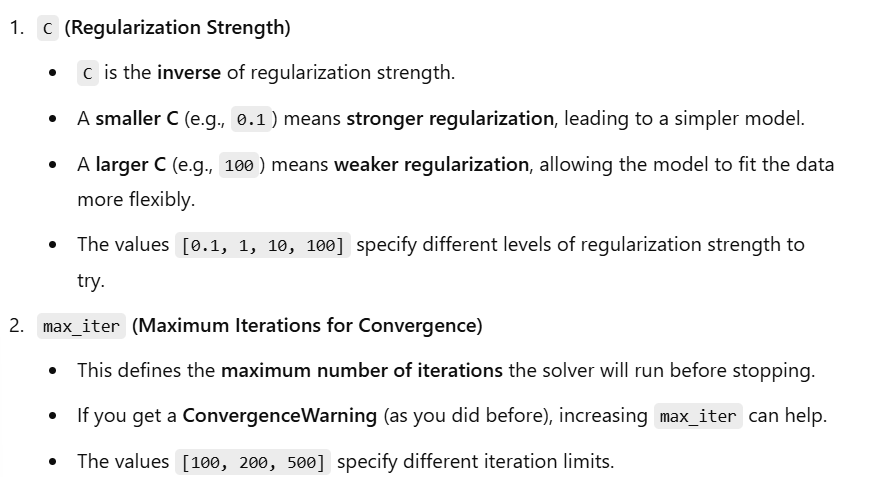 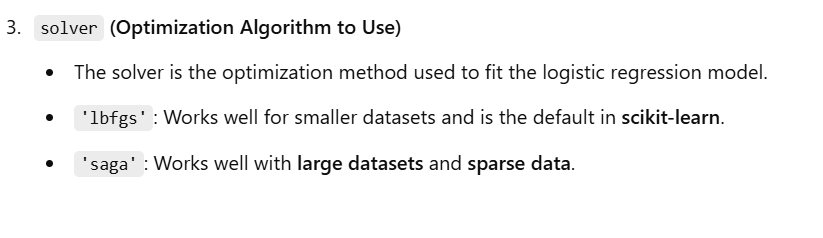

In [20]:
#2 RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the parameters
param_dist = {
    'C':[0.1,1,10,100],
    'max_iter':[100,200,500],
    'solver':['lbfgs','saga']
}

#Initialize logistic regression model
model =LogisticRegression(random_state=42)

#Initailize gridsearhCV
random_search = RandomizedSearchCV(estimator=model,param_distributions=param_dist,cv=5,n_jobs=-1,scoring='accuracy',random_state=42)

#Fit the model
random_search.fit(x_train,y_train)

#Get the best parameters
print(f'Best parameters: {random_search.best_params_}')

#Get teh best model
best_model = random_search.best_estimator_

#Evalaute the best model
cv_results = cross_validate(best_model,x_train,y_train,cv=5,scoring=['accuracy','precision','recall','f1'])

print(f"\nMean Accuracy:{np.mean(cv_results['test_accuracy']):.4f}")
print(f"Mean Precision:{np.mean(cv_results['test_precision']):.4f}")
print(f"Mean Recall:{np.mean(cv_results['test_recall']):.4f}")
print(f"Mean F1-score:{np.mean(cv_results['test_f1']):.4f}")

Best parameters: {'solver': 'lbfgs', 'max_iter': 100, 'C': 0.1}

Mean Accuracy:0.7090
Mean Precision:0.7094
Mean Recall:0.7094
Mean F1-score:0.7094


#10 Feature Selection

To enhance model performance, you can apply feature selection techniques. One common method is Recursive Feature Elimination (RFE), which selects the best features by recursively removing the least important ones.

In [21]:
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='saga',max_iter=500,random_state=42)

selector = RFE(model,n_features_to_select=5) #Select the top 5 features

selector = selector.fit(x_train,y_train)

selected_features = x.columns[selector.get_support()]

print(f'Selected Features: {selected_features}')

Selected Features: Index(['Payment Method_Credit Card', 'Payment Method_PayPal',
       'Product Category_Clothing', 'Product Category_Electronics',
       'Product Category_Home'],
      dtype='object')


In [22]:
# Train the model using only the selected features

x_train_selected = x_train[:,selector.get_support()]
x_test_selected = x_test[:,selector.get_support()]

model = LogisticRegression(max_iter=500, random_state=42)

model.fit(x_train_selected,y_train)

y_pred = model.predict(x_test_selected)

# Evaluate
from sklearn.metrics import classification_report,accuracy_score
accuracy = accuracy_score (y_test,y_pred)
print('Accuracy:',accuracy)

print('\nclassification_report:\n',classification_report(y_test,y_pred))


Accuracy: 0.6442586361970752

classification_report:
               precision    recall  f1-score   support

           0       0.71      0.51      0.59     30258
           1       0.61      0.79      0.69     29780

    accuracy                           0.64     60038
   macro avg       0.66      0.65      0.64     60038
weighted avg       0.66      0.64      0.64     60038



#11 Model Comparision

In [23]:
# # Random Forest Classifier
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.model_selection import cross_val_score 

# rf_model = RandomForestClassifier(random_state=42)

# rf_cv_results = cross_val_score(rf_model,x_train,y_train,cv=5,scoring='accuracy')
# print(f'Random Forest Accuracy: {np.mean(rf_cv_results):.4f}') 

In [24]:
# # SVM
# from sklearn.svm import SVC
# from sklearn.model_selection import cross_val_score 

# svm_model = SVC(random_state=42)

# svm_cv_results = cross_val_score(svm_model,x_train,y_train,cv=5,scoring='accuracy')
# print(f'SVM Accuracy: {np.mean(svm_cv_results):.4f}') 

In [25]:
# # Compare Models
# from sklearn.svm import SVC
# from sklearn.model_selection import cross_val_score 
# models = ['Logistic Regression', 'Random Forest', 'SVM']
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# # Store results
# results = []

# for model, scores in zip(models, [cv_results, rf_cv_results, svm_cv_results]):
#     results.append([
#         np.mean(scores['test_accuracy']),
#         np.mean(scores['test_precision']),
#         np.mean(scores['test_recall']),
#         np.mean(scores['test_f1'])
#     ])

# # Print results
# df_results = pd.DataFrame(results, columns=metrics, index=models)
# print(df_results)


In [29]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
# from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    # 'SVM': SVC()
}

# Evaluate models
results = []
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

# Convert results to a DataFrame & sort by F1-score
results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
print(results_df)

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")





# # Reduce dataset size for initial testing (Optional)
# x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, test_size=0.8, random_state=42)

# # Define optimized models
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=500, solver='lbfgs'),
#     'Random Forest': RandomForestClassifier(n_estimators=50, n_jobs=-1),
#     'Gradient Boosting': GradientBoostingClassifier(n_estimators=50),
#     'SVM': SVC(kernel='linear')  # Linear kernel is faster
# }

# # Evaluate models
# results = []
# for name, model in models.items():
#     print(f"Training {name}...")
#     model.fit(x_train_small, y_train_small)  # Use smaller dataset for quick testing
#     y_pred = model.predict(x_test)

#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
    
#     results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

# # Convert results to DataFrame & sort by F1-score
# results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
# print(results_df)

# # Select best model
# best_model_name = results_df.iloc[0]['Model']
# best_model = models[best_model_name]
# print(f"Best Model: {best_model_name}")

                 Model  Accuracy  Precision    Recall  F1-score
1        Random Forest  0.822462   0.926142  0.697717  0.795863
2    Gradient Boosting  0.796512   0.986968  0.597649  0.744484
0  Logistic Regression  0.710283   0.707540  0.708966  0.708252
Best Model: Random Forest


#12 Final Model Training and Testing

In [27]:
final_model = best_model
final_model.fit(x_train,y_train)

y_pred = final_model.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report:\n', classification_report(y_test,y_pred))
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.95      0.84     30258
           1       0.93      0.70      0.79     29780

    accuracy                           0.82     60038
   macro avg       0.84      0.82      0.82     60038
weighted avg       0.84      0.82      0.82     60038

Confusion Matrix:
 [[28597  1661]
 [ 9046 20734]]


#13 Model Interpretation

In [28]:
# Feature importance for Random Forest or Logistic Regression
if hasattr(final_model, 'coef_'):
    print(f"Coefficients: {final_model.coef_}")
elif hasattr(final_model, 'feature_importances_'):
    print(f"Feature Importances: {final_model.feature_importances_}")

Feature Importances: [0.11157401 0.04866458 0.11560057 0.07029791 0.15224714 0.07005943
 0.03792625 0.06383598 0.08446992 0.02881653 0.04282429 0.02947935
 0.0507557  0.03094481 0.031588   0.03091552]
